# Phân cụm dữ liệu đồng hồ bằng Agglomerative Clustering

Agglomerative Clustering là một thuật toán phân cụm phân cấp (hierarchical clustering) theo hướng tiếp cận từ dưới lên (bottom-up). Thuật toán bắt đầu với mỗi điểm dữ liệu là một cụm riêng biệt, sau đó liên tục hợp nhất (merge) các cụm gần nhau cho đến khi đạt được số lượng cụm mong muốn hoặc tất cả các điểm được gộp vào một cụm duy nhất.

## Ưu điểm của Agglomerative Clustering:
- Không yêu cầu xác định số lượng cụm trước (có thể xác định sau bằng dendrogram)
- Linh hoạt với nhiều phương pháp đo khoảng cách (linkage) khác nhau
- Hiệu quả với các cụm có hình dạng không đều hoặc kích thước khác nhau
- Tạo ra cấu trúc phân cấp giúp hiểu rõ mối quan hệ giữa các cụm

## Các tham số quan trọng:
- **n_clusters**: Số lượng cụm
- **linkage**: Phương pháp tính khoảng cách giữa các cụm ('ward', 'complete', 'average', 'single')
- **affinity**: Phương pháp tính khoảng cách giữa các điểm dữ liệu ('euclidean', 'manhattan', 'cosine',...)

In [18]:
!pip install kmodes

# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kmodes.kprototypes import KPrototypes
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho các biểu đồ
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## 1. Đọc và khám phá dữ liệu

Chúng ta sẽ làm việc với bộ dữ liệu đồng hồ đã được phân đoạn. Mỗi mẫu dữ liệu chứa thông tin về các đặc điểm của đồng hồ như chất liệu, thương hiệu, kích thước, độ chống nước, v.v.

In [19]:
# Đọc dữ liệu
file_path = '../dataset/train_segmented.csv'
df = pd.read_csv(file_path)

# Tạo bản sao của dữ liệu gốc để tham khảo sau này
df_original = df.copy()

# Hiển thị thông tin cơ bản về dữ liệu
print("=== THÔNG TIN DỮ LIỆU ===")
print(f"Kích thước dữ liệu: {df.shape}")
print("\nThông tin các cột:")
df.info()

print("\n=== MẪU DỮ LIỆU ===")
print(df.head())

print("\n=== THỐNG KÊ MÔ TẢ CHO CÁC ĐẶC TRƯNG SỐ ===")
print(df[['case_thickness', 'case_diameter', 'water_resistance']].describe())

=== THÔNG TIN DỮ LIỆU ===
Kích thước dữ liệu: (5665, 15)

Thông tin các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   case_material     5665 non-null   object 
 1   band_material     5665 non-null   object 
 2   case_back         5665 non-null   object 
 3   bezel_material    5665 non-null   object 
 4   brand             5665 non-null   object 
 5   gender            5665 non-null   object 
 6   movement          5665 non-null   object 
 7   watch_style       5665 non-null   object 
 8   case_thickness    5665 non-null   float64
 9   crystal           5665 non-null   object 
 10  hands             5665 non-null   object 
 11  dial_markers      5665 non-null   object 
 12  case_diameter     5665 non-null   float64
 13  water_resistance  5665 non-null   float64
 14  price_segment     5665 non-null   int64  
dtypes: float64(3

## 2. Tiền xử lý dữ liệu

Trước khi áp dụng Agglomerative Clustering, chúng ta cần chuẩn bị dữ liệu:
1. Xác định các loại biến (số, phân loại)
2. Xử lý các giá trị hiếm trong biến phân loại (category pooling)
3. Mã hóa biến phân loại (one-hot encoding, frequency encoding)
4. Chuẩn hóa các biến số

Agglomerative Clustering rất nhạy cảm với tỷ lệ của các đặc trưng, vì vậy việc chuẩn hóa dữ liệu là bắt buộc.

In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Xác định các loại cột
numerical_cols = ['case_thickness', 'case_diameter', 'water_resistance']
onehot_cols = ['gender', 'movement', 'watch_style']
categorical_cols = ['case_material', 'band_material', 'case_back', 'bezel_material', 
                    'brand', 'crystal', 'hands', 'dial_markers']

all_categorical_cols = onehot_cols + categorical_cols
high_card_cols = [col for col in all_categorical_cols if df[col].nunique() > 10]
low_card_cols = [col for col in all_categorical_cols if col not in high_card_cols]

# Category pooling (gộp nhóm các giá trị hiếm) - quan trọng cho Agglomerative Clustering
def pool_categories(series, threshold=0.01):
    value_counts = series.value_counts(normalize=True)
    rare = value_counts[value_counts < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

# Gộp giá trị hiếm cho các cột có nhiều category
df_processed = df.copy()
for col in high_card_cols:
    df_processed[col] = pool_categories(df_processed[col])

# Frequency Encoding cho các cột có nhiều category sau khi đã gộp
for col in high_card_cols:
    freq_map = df_processed[col].value_counts(normalize=True).to_dict()
    df_processed[col] = df_processed[col].map(freq_map)

# One-hot Encoding cho các cột có ít category
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
if low_card_cols:
    onehot_encoded = pd.DataFrame(
        onehot_encoder.fit_transform(df_processed[low_card_cols]),
        columns=onehot_encoder.get_feature_names_out(low_card_cols)
    )
    
    # Chuẩn hóa dữ liệu số - cần thiết cho Agglomerative Clustering
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_agg = pd.concat([
        scaled_numerical,
        onehot_encoded,
        df_processed[high_card_cols]
    ], axis=1)
else:
    # Chuẩn hóa dữ liệu số
    scaler = StandardScaler()
    scaled_numerical = pd.DataFrame(
        scaler.fit_transform(df_processed[numerical_cols]),
        columns=numerical_cols
    )
    
    # Kết hợp dữ liệu đã xử lý
    df_agg = pd.concat([
        scaled_numerical,
        df_processed[high_card_cols]
    ], axis=1)

print("\n=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===")
print("\nDữ liệu đã được chuẩn hóa và mã hóa:")
print(df_agg.head())
print(f"\nKích thước dữ liệu: {df_agg.shape}")

# Lưu dữ liệu đã xử lý
df_agg.to_csv('../dataset/train_agglomerative_processed.csv', index=False)


=== KIỂM TRA DỮ LIỆU SAU KHI TIỀN XỬ LÝ CHO AGGLOMERATIVE CLUSTERING ===

Dữ liệu đã được chuẩn hóa và mã hóa:
   case_thickness  case_diameter  water_resistance  gender_UNISEX  \
0       -0.962829      -0.767582         -0.281839            0.0   
1       -0.687852      -0.097288         -0.281839            0.0   
2        0.215643       1.075727          0.006708            0.0   
3       -1.316370      -1.437877         -0.397257            0.0   
4       -0.021551       0.237859         -0.281839            0.0   

   gender_WOMENS  movement_Eco-Drive  movement_Hand Wind  movement_Quartz  \
0            1.0                 0.0                 0.0              0.0   
1            0.0                 0.0                 0.0              1.0   
2            0.0                 0.0                 0.0              1.0   
3            1.0                 0.0                 0.0              1.0   
4            0.0                 0.0                 0.0              1.0   

   watch_s

## 3. Xác định số cụm tối ưu

Để xác định số cụm tối ưu trong Agglomerative Clustering, chúng ta có thể sử dụng:
1. **Dendrogram**: Biểu đồ cây phân cấp giúp trực quan hóa quá trình hợp nhất các cụm
2. **Các chỉ số đánh giá**: Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index

Một dendrogram cho phép chúng ta thấy các cụm được hợp nhất theo từng bước. Khoảng cách mà tại đó các cụm được hợp nhất là một chỉ báo về mức độ tương đồng giữa chúng. Chúng ta có thể "cắt" dendrogram tại một độ cao nào đó để xác định số cụm.

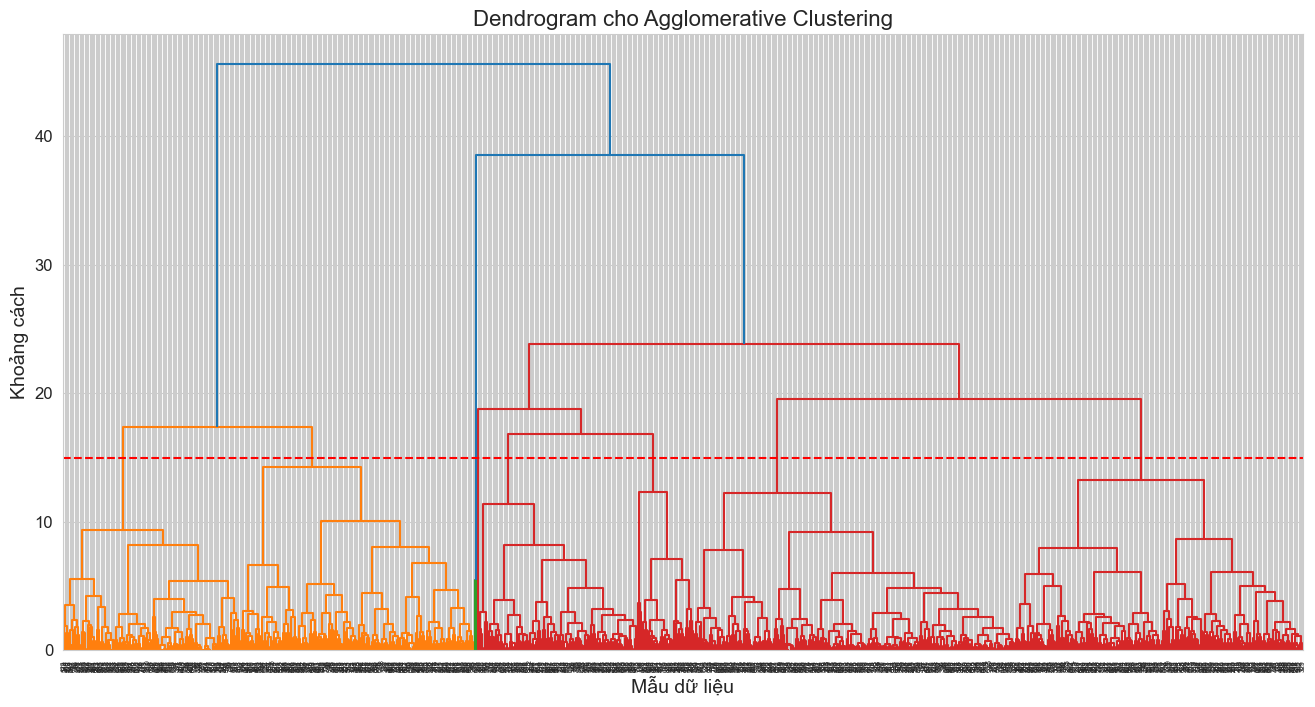

In [21]:
# Vẽ dendrogram để xác định số cụm tối ưu
plt.figure(figsize=(16, 8))
plt.title('Dendrogram cho Agglomerative Clustering', fontsize=16)
plt.xlabel('Mẫu dữ liệu', fontsize=14)
plt.ylabel('Khoảng cách', fontsize=14)

# Sử dụng mẫu nhỏ nếu dữ liệu quá lớn
sample_size = min(1000, len(df_agg))
sample_data = df_agg.sample(sample_size, random_state=42) if len(df_agg) > sample_size else df_agg

# Tính toán linkage matrix
linkage_matrix = linkage(sample_data, method='ward')

# Vẽ dendrogram
dendrogram(linkage_matrix)
plt.axhline(y=15, color='r', linestyle='--')  # Đường tham chiếu để chọn số cụm
plt.show()

Nhìn vào dendrogram, chúng ta có thể thấy các nhánh hợp nhất. Khoảng cách giữa các nhánh càng lớn (chiều cao càng cao) thì sự khác biệt giữa các cụm càng lớn. Đường màu đỏ đứt nét cho thấy một ngưỡng để cắt dendrogram, tạo ra một số lượng cụm hợp lý.

Tiếp theo, chúng ta sẽ đánh giá các phương án khác nhau về số lượng cụm bằng các chỉ số đánh giá:

1. **Silhouette Score**: Đo lường mức độ tách biệt giữa các cụm. Giá trị từ -1 đến 1, càng gần 1 càng tốt.
2. **Davies-Bouldin Index**: Đo lường sự phân tán trong cụm và khoảng cách giữa các cụm. Giá trị càng thấp càng tốt.
3. **Calinski-Harabasz Index**: Đánh giá tỷ lệ phương sai giữa các cụm và trong cụm. Giá trị càng cao càng tốt.

In [22]:
# Thử nghiệm với một số lượng cụm khác nhau
n_clusters_list = [2, 3, 4, 5, 6, 7, 8]
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in n_clusters_list:
    # Áp dụng Agglomerative Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(df_agg)
    
    # Tính các chỉ số đánh giá
    silhouette = silhouette_score(df_agg, cluster_labels)
    davies_bouldin = davies_bouldin_score(df_agg, cluster_labels)
    calinski_harabasz = calinski_harabasz_score(df_agg, cluster_labels)
    
    # Lưu kết quả
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    
    print(f"n_clusters = {n_clusters}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz:.4f}")



n_clusters = 2:
  Silhouette Score: 0.2665
  Davies-Bouldin Score: 1.4043
  Calinski-Harabasz Score: 1754.2411
n_clusters = 3:
  Silhouette Score: 0.2723
  Davies-Bouldin Score: 1.0051
  Calinski-Harabasz Score: 1618.7676
n_clusters = 4:
  Silhouette Score: 0.1456
  Davies-Bouldin Score: 1.4441
  Calinski-Harabasz Score: 1415.9526
n_clusters = 5:
  Silhouette Score: 0.1540
  Davies-Bouldin Score: 1.3627
  Calinski-Harabasz Score: 1287.6890
n_clusters = 6:
  Silhouette Score: 0.1561
  Davies-Bouldin Score: 1.5424
  Calinski-Harabasz Score: 1176.9280
n_clusters = 7:
  Silhouette Score: 0.1432
  Davies-Bouldin Score: 1.6121
  Calinski-Harabasz Score: 1120.0489
n_clusters = 8:
  Silhouette Score: 0.1515
  Davies-Bouldin Score: 1.5445
  Calinski-Harabasz Score: 1048.8867


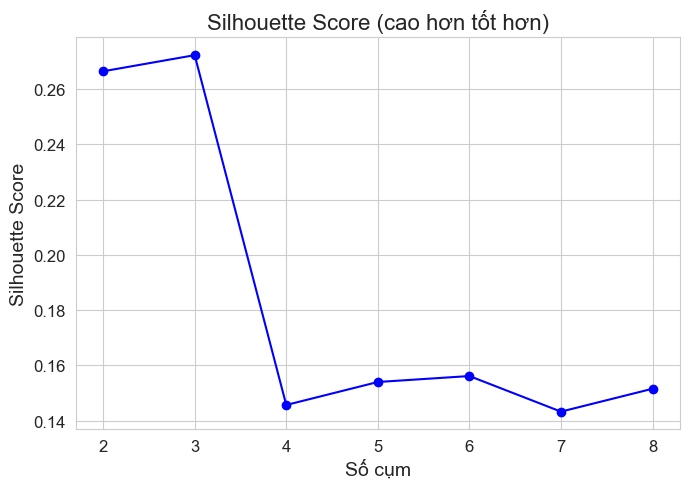

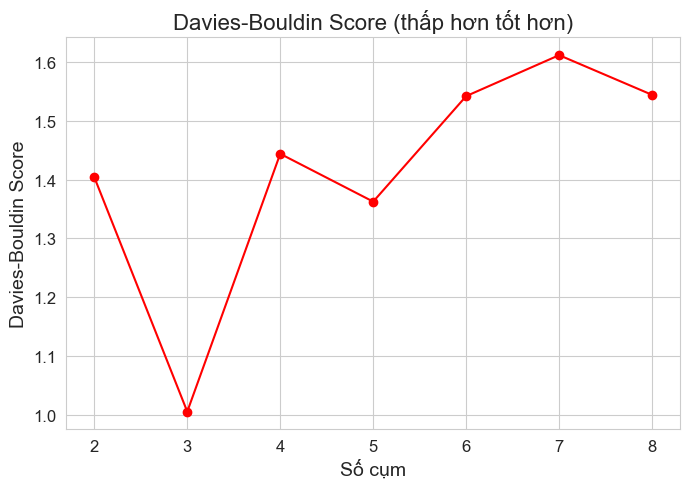

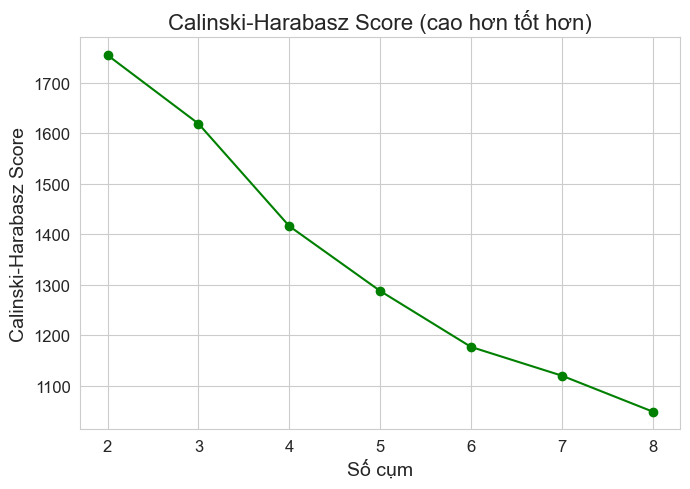

In [23]:
# Biểu đồ 1: Silhouette Score
plt.figure(figsize=(7, 5))
plt.plot(n_clusters_list, silhouette_scores, 'o-', color='blue')
plt.xlabel('Số cụm')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score (cao hơn tốt hơn)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Biểu đồ 2: Davies-Bouldin Score
plt.figure(figsize=(7, 5))
plt.plot(n_clusters_list, davies_bouldin_scores, 'o-', color='red')
plt.xlabel('Số cụm')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score (thấp hơn tốt hơn)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Biểu đồ 3: Calinski-Harabasz Score
plt.figure(figsize=(7, 5))
plt.plot(n_clusters_list, calinski_harabasz_scores, 'o-', color='green')
plt.xlabel('Số cụm')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score (cao hơn tốt hơn)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Xây dựng mô hình Agglomerative Clustering

Sau khi đã đánh giá số cụm tối ưu, chúng ta sẽ xây dựng mô hình Agglomerative Clustering chính thức. Chúng ta sẽ sử dụng Silhouette Score làm tiêu chí chính để chọn số cụm.


Số cụm tối ưu dựa trên Silhouette Score: 3

=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===
cluster
0    3801
1    1858
2       6
Name: count, dtype: int64

Phần trăm phân phối:
cluster
0    67.096205
1    32.797882
2     0.105914
Name: count, dtype: float64


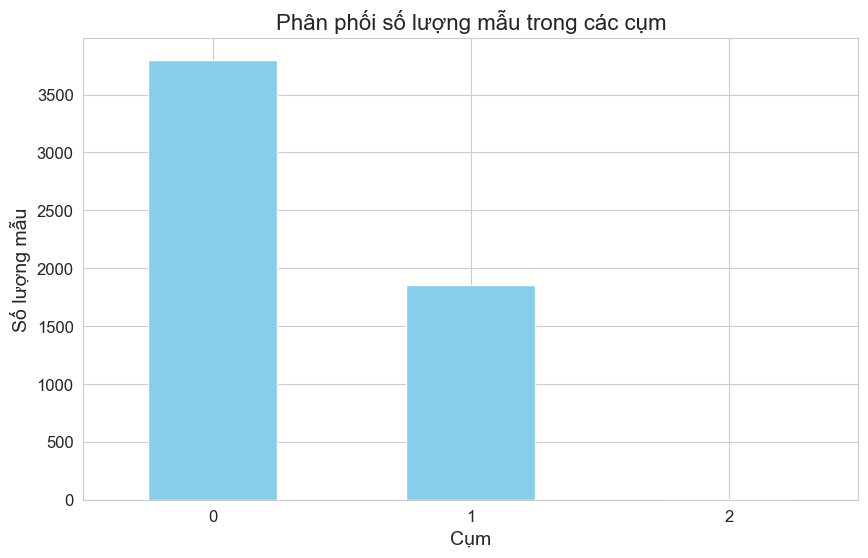

In [24]:
# Chọn số cụm tối ưu dựa trên kết quả
optimal_n_clusters = n_clusters_list[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu dựa trên Silhouette Score: {optimal_n_clusters}")

# Áp dụng Agglomerative Clustering với số cụm tối ưu
final_model = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
df['cluster'] = final_model.fit_predict(df_agg)

# Phân tích kết quả phân cụm
print("\n=== PHÂN TÍCH PHÂN PHỐI CỦA CÁC CỤM ===")
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)
print("\nPhần trăm phân phối:")
print(100 * cluster_counts / len(df))

# Trực quan hóa phân phối cụm
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Phân phối số lượng mẫu trong các cụm')
plt.xlabel('Cụm')
plt.ylabel('Số lượng mẫu')
plt.xticks(rotation=0)
plt.show()

## 5. Trực quan hóa kết quả phân cụm

Để hiểu rõ hơn về các cụm, chúng ta sẽ sử dụng PCA (Principal Component Analysis) để giảm chiều dữ liệu xuống 2 chiều và trực quan hóa kết quả phân cụm.

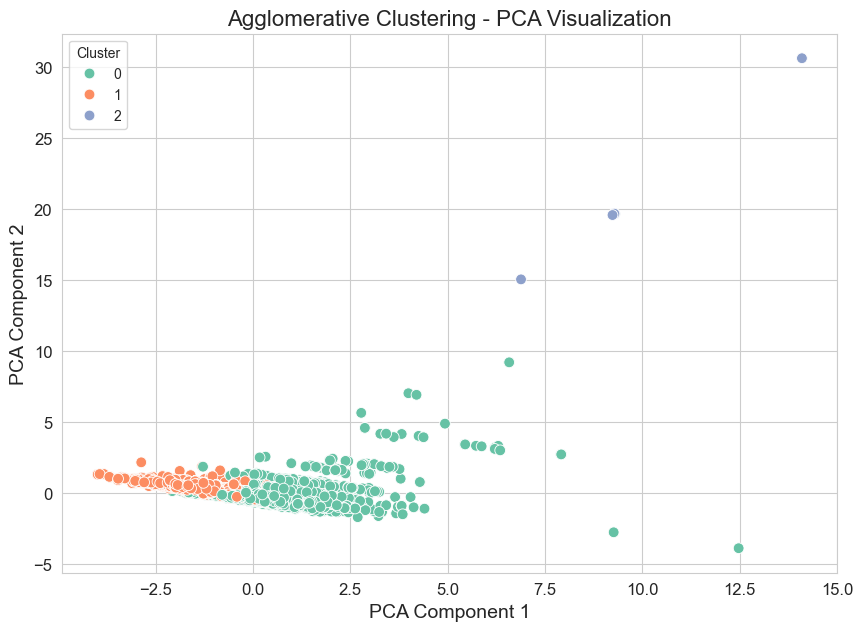

Phương sai giải thích bởi 2 thành phần chính: 60.11%
PCA1: 40.22%, PCA2: 19.89%


In [25]:
# Giảm chiều dữ liệu xuống 2 thành phần chính
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_agg)

# Thêm vào DataFrame gốc
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Trực quan hóa
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='cluster', palette='Set2', s=60)
plt.title('Agglomerative Clustering - PCA Visualization', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Hiển thị phương sai giải thích bởi các thành phần chính
explained_variance = pca.explained_variance_ratio_
print(f"Phương sai giải thích bởi 2 thành phần chính: {sum(explained_variance)*100:.2f}%")
print(f"PCA1: {explained_variance[0]*100:.2f}%, PCA2: {explained_variance[1]*100:.2f}%")

In [26]:
# Lọc bỏ cụm nhiễu (ví dụ cụm 2)
df_cleaned = df[df['cluster'] != 2].copy()

df = df_cleaned.copy()

# Kiểm tra lại
print("Kích thước dữ liệu sau khi loại cụm nhiễu:", df_cleaned.shape)


Kích thước dữ liệu sau khi loại cụm nhiễu: (5659, 18)


## 6. Phân tích đặc điểm của các cụm

### 6.1. Phân tích đặc trưng số

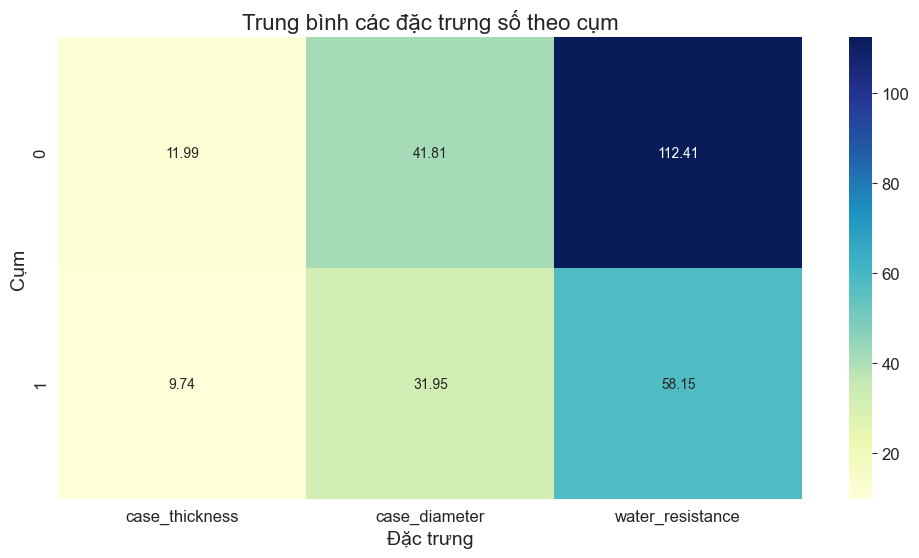

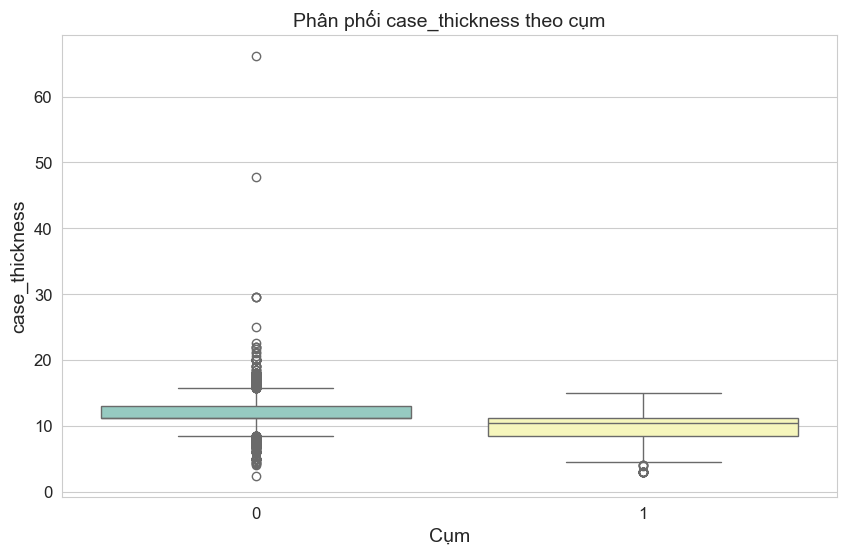

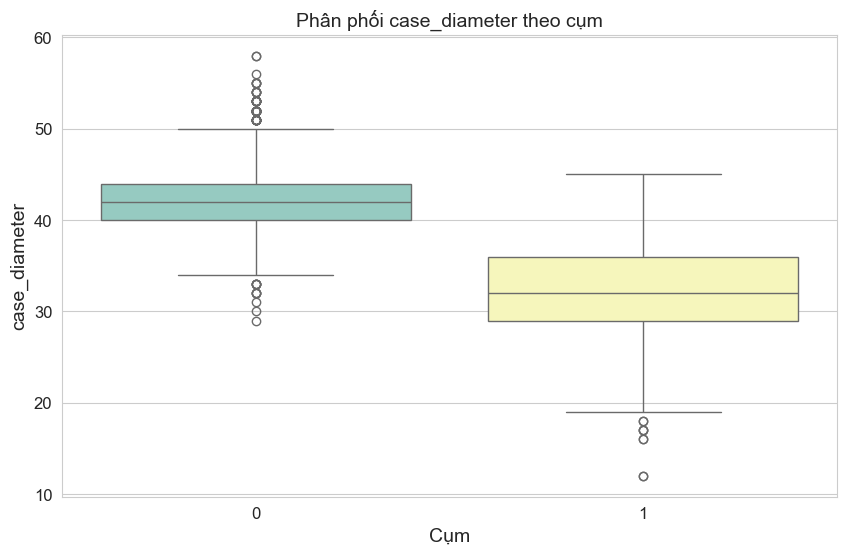

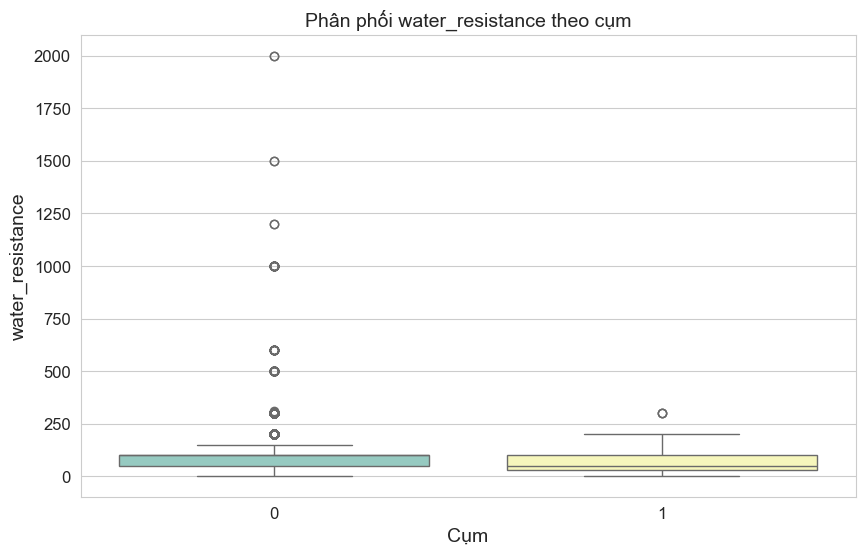

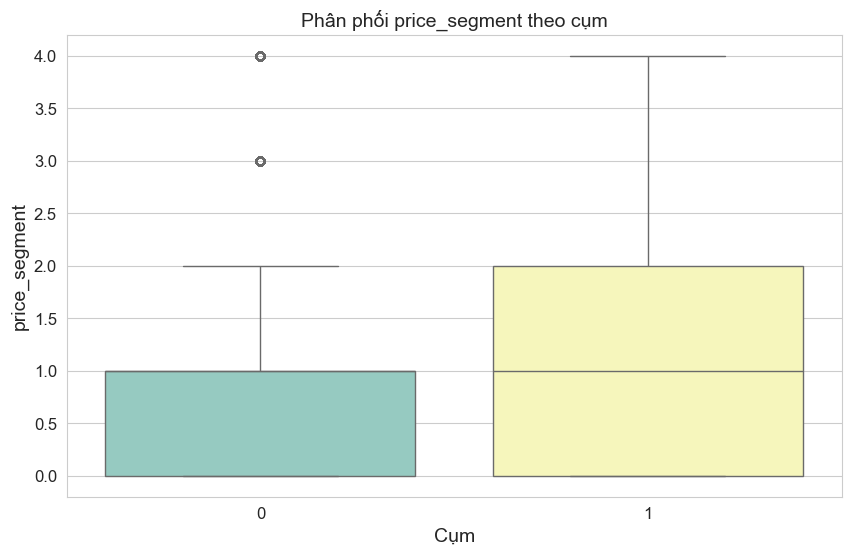

In [27]:
# Tính trung bình mỗi cột theo cụm
cluster_means = df.groupby('cluster')[numerical_cols].mean()

# Vẽ heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Trung bình các đặc trưng số theo cụm', fontsize=16)
plt.ylabel('Cụm')
plt.xlabel('Đặc trưng')
plt.show()

# Biểu đồ hộp cho từng đặc trưng số theo cụm
for col in numerical_cols + ['price_segment']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='cluster', y=col, palette='Set3')
    plt.title(f'Phân phối {col} theo cụm', fontsize=14)
    plt.xlabel('Cụm')
    plt.ylabel(col)
    plt.show()

### 6.2. Phân tích đặc trưng phân loại

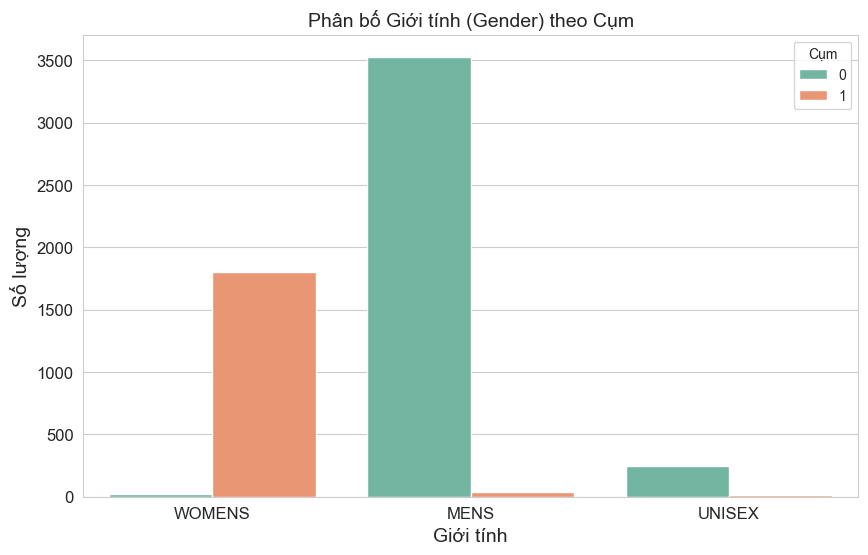

<Figure size 1000x600 with 0 Axes>

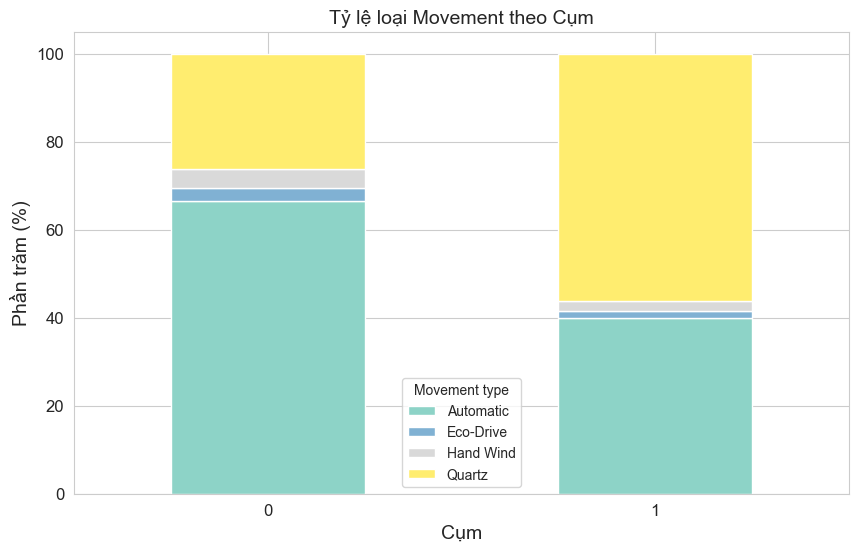

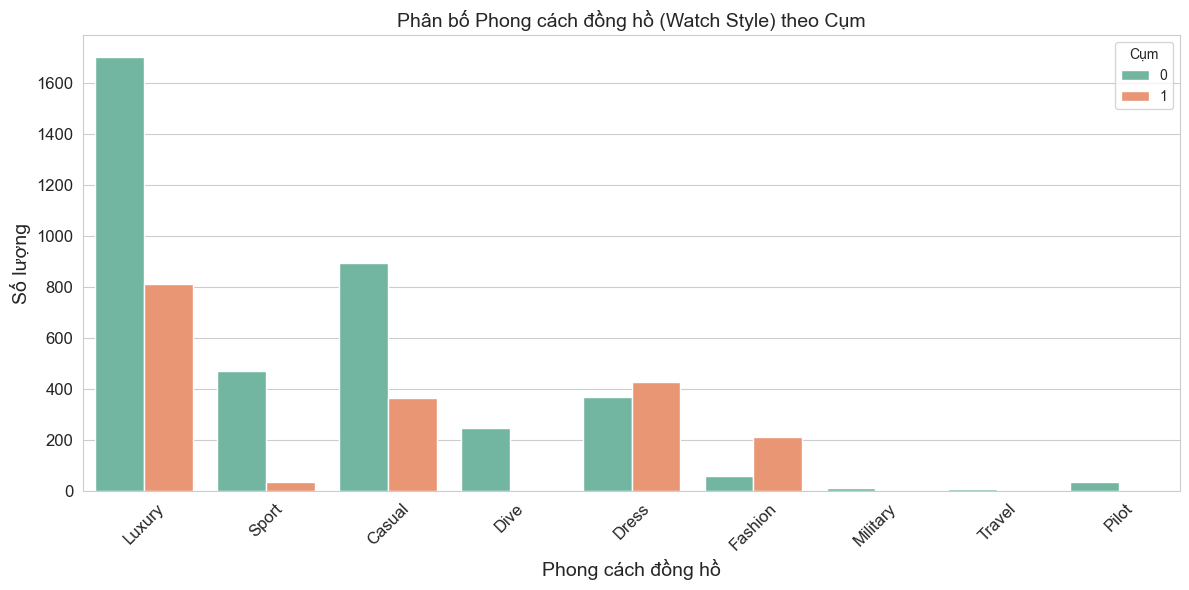

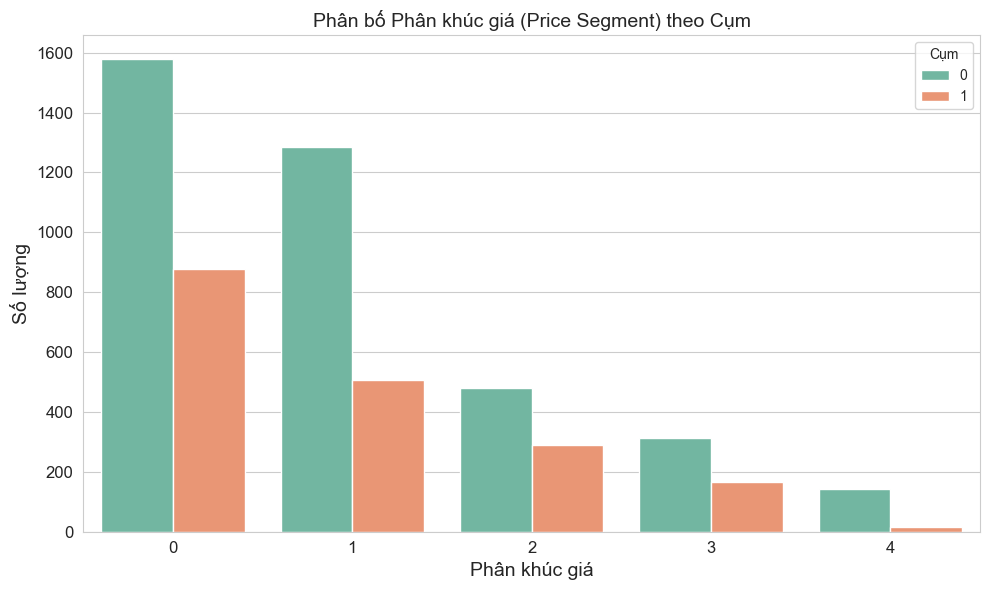

In [28]:
# Gender distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='cluster', data=df, palette='Set2')
plt.title('Phân bố Giới tính (Gender) theo Cụm', fontsize=14)
plt.xlabel('Giới tính')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.show()

# Movement type distribution by cluster
plt.figure(figsize=(10, 6))
movement_counts = df.groupby(['cluster', 'movement']).size().unstack()
movement_proportions = movement_counts.div(movement_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
movement_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set3')
plt.title('Tỷ lệ loại Movement theo Cụm', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Movement type')
plt.xticks(rotation=0)
plt.show()

# Watch style distribution by cluster
plt.figure(figsize=(12, 6))
sns.countplot(x='watch_style', hue='cluster', data=df, palette='Set2')
plt.title('Phân bố Phong cách đồng hồ (Watch Style) theo Cụm', fontsize=14)
plt.xlabel('Phong cách đồng hồ')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# price_segment distribution by cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='price_segment', hue='cluster', data=df, palette='Set2')
plt.title('Phân bố Phân khúc giá (Price Segment) theo Cụm', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Số lượng')
plt.legend(title='Cụm')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




Tỷ lệ price_segment trong mỗi cụm (%):
price_segment     0     1     2    3    4
cluster                                  
0              41.5  33.8  12.6  8.2  3.8
1              47.2  27.3  15.6  9.0  0.9


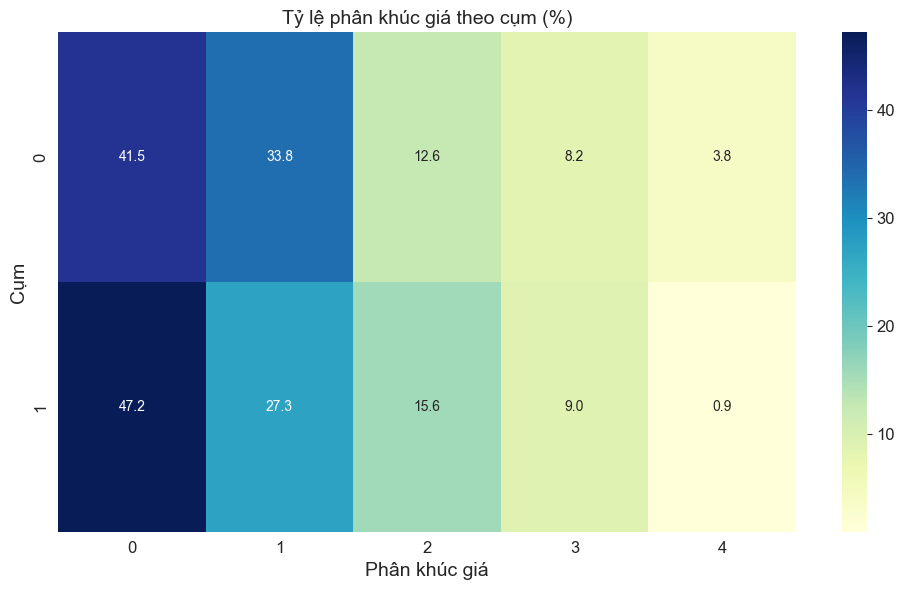

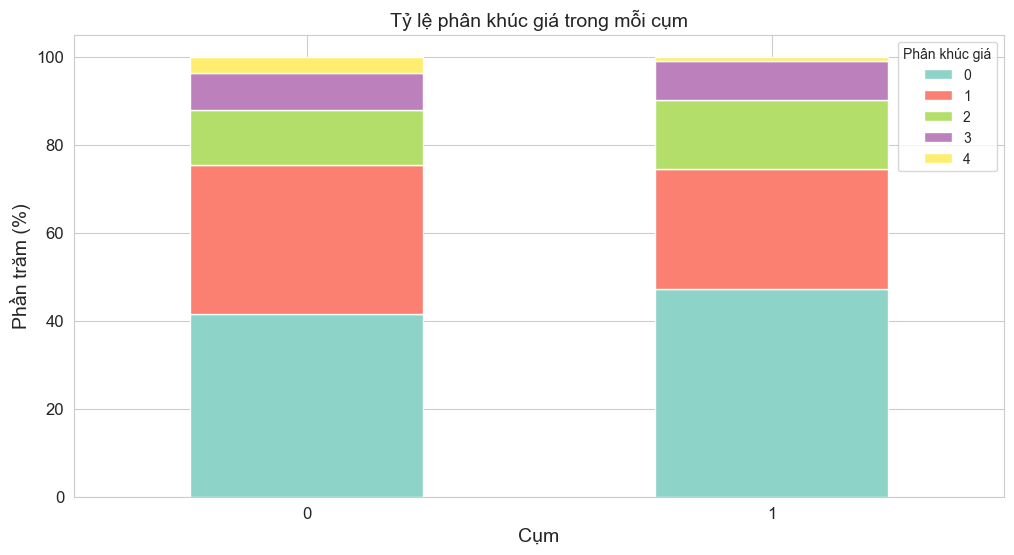

Chi-square statistic: 70.85
p-value: 0.0000
Degrees of freedom: 4
Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá


In [29]:
# Tạo bảng tỷ lệ price_segment trong mỗi cụm
segment_cluster_df = pd.crosstab(df['cluster'], df['price_segment'], normalize='index') * 100
segment_cluster_df = segment_cluster_df.round(1)  # Làm tròn đến 1 chữ số thập phân

# Hiển thị bảng
print("Tỷ lệ price_segment trong mỗi cụm (%):")
print(segment_cluster_df)

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(segment_cluster_df, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Tỷ lệ phân khúc giá theo cụm (%)', fontsize=14)
plt.xlabel('Phân khúc giá')
plt.ylabel('Cụm')
plt.tight_layout()
plt.show()


# Vẽ biểu đồ cột chồng thể hiện tỷ lệ price_segment trong mỗi cụm
segment_counts = df.groupby(['cluster', 'price_segment']).size().unstack()
segment_proportions = segment_counts.div(segment_counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
segment_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set3')
plt.title('Tỷ lệ phân khúc giá trong mỗi cụm', fontsize=14)
plt.xlabel('Cụm')
plt.ylabel('Phần trăm (%)')
plt.legend(title='Phân khúc giá')
plt.xticks(rotation=0)
plt.show()


from scipy.stats import chi2_contingency

# Tạo bảng tần số
contingency_table = pd.crosstab(df['cluster'], df['price_segment'])

# Thực hiện kiểm định chi-square
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print("Kết luận: Có mối liên hệ có ý nghĩa thống kê giữa cụm và phân khúc giá" if p < 0.05 else "Kết luận: Không có mối liên hệ có ý nghĩa thống kê")




### 6.3. Phân tích thương hiệu (Brand)

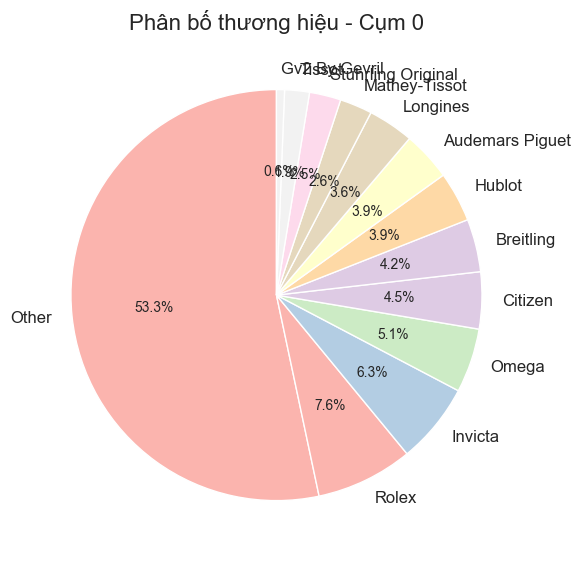

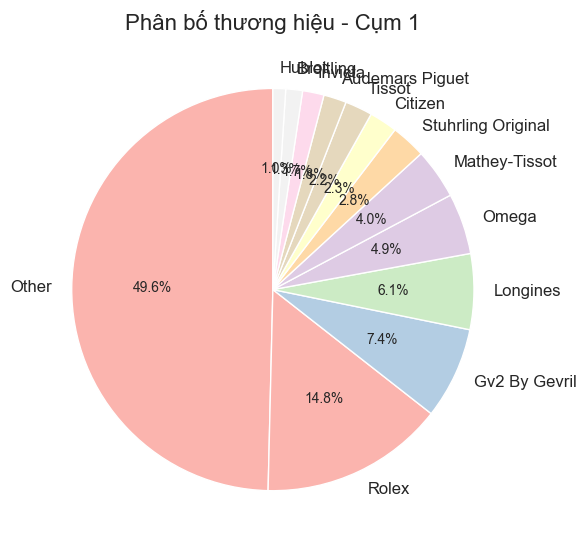

In [30]:
# Bước chuẩn hóa: Gộp thương hiệu hiếm thành 'Other'
df['brand_pooled'] = pool_categories(df['brand'], threshold=0.02)

# Vẽ biểu đồ tròn theo cụm sau khi đã pooling
for cluster_id in sorted(df['cluster'].unique()):
    plt.figure(figsize=(6, 6))
    brand_counts = df[df['cluster'] == cluster_id]['brand_pooled'].value_counts()
    brand_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Pastel1')
    plt.title(f"Phân bố thương hiệu - Cụm {cluster_id}")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

## 7. Phân tích đa chiều (Multivariate Analysis)

Phân tích đa chiều giúp chúng ta thấy mối quan hệ giữa các đặc trưng và cách chúng phân biệt các cụm. Biểu đồ tọa độ song song (Parallel Coordinates) là một công cụ hữu ích để hiển thị nhiều đặc trưng và cách chúng phân biệt các cụm.

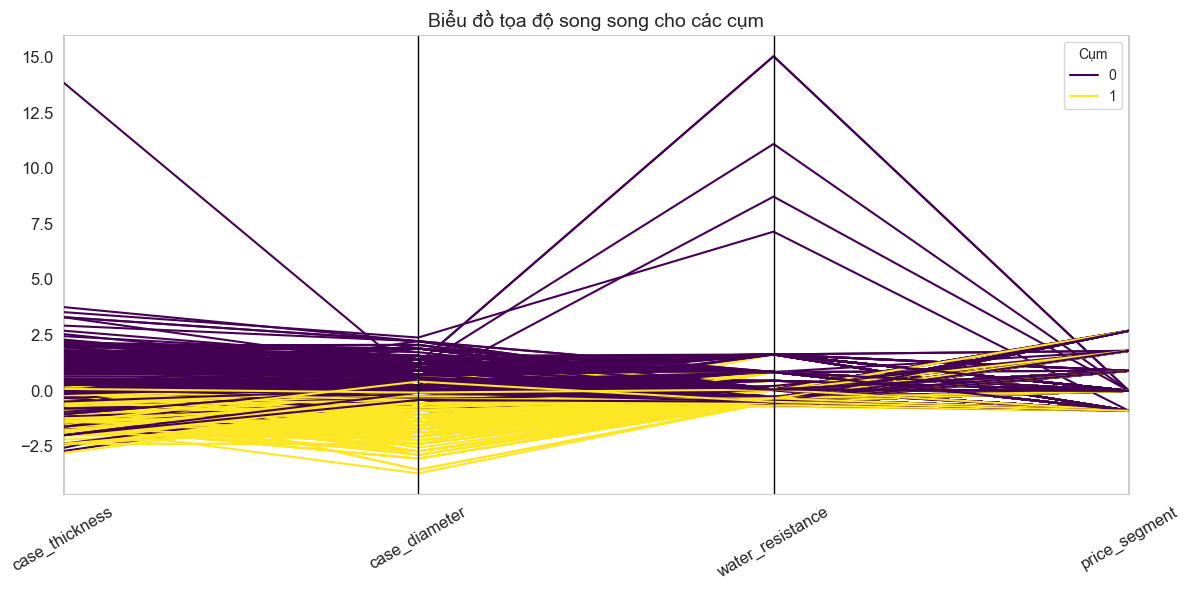

In [31]:
from pandas.plotting import parallel_coordinates

# Chọn các đặc trưng phù hợp
parallel_features = numerical_cols + ['price_segment']

# Lấy mẫu nếu dữ liệu quá lớn
sample_size = min(1000, len(df))
df_sample = df.sample(sample_size, random_state=42) if len(df) > sample_size else df

# Tạo DataFrame mới với các đặc trưng đã chọn và cụm
parallel_df = df_sample[parallel_features + ['cluster']].copy()

# Chuẩn hóa các đặc trưng để dễ dàng so sánh
scaler = StandardScaler()
parallel_df[parallel_features] = scaler.fit_transform(parallel_df[parallel_features])

# Vẽ biểu đồ tọa độ song song
plt.figure(figsize=(12, 6))
parallel_coordinates(parallel_df, 'cluster', colormap='viridis')
plt.title('Biểu đồ tọa độ song song cho các cụm', fontsize=14)
plt.grid(False)
plt.legend(title='Cụm')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## 8. Phân tích mối quan hệ giữa các đặc trưng

Pairplot cho phép chúng ta xem mối quan hệ giữa các cặp đặc trưng số và cách chúng phân tách các cụm. Điều này giúp chúng ta hiểu rõ hơn về cách các cụm được phân biệt trong không gian đa chiều.

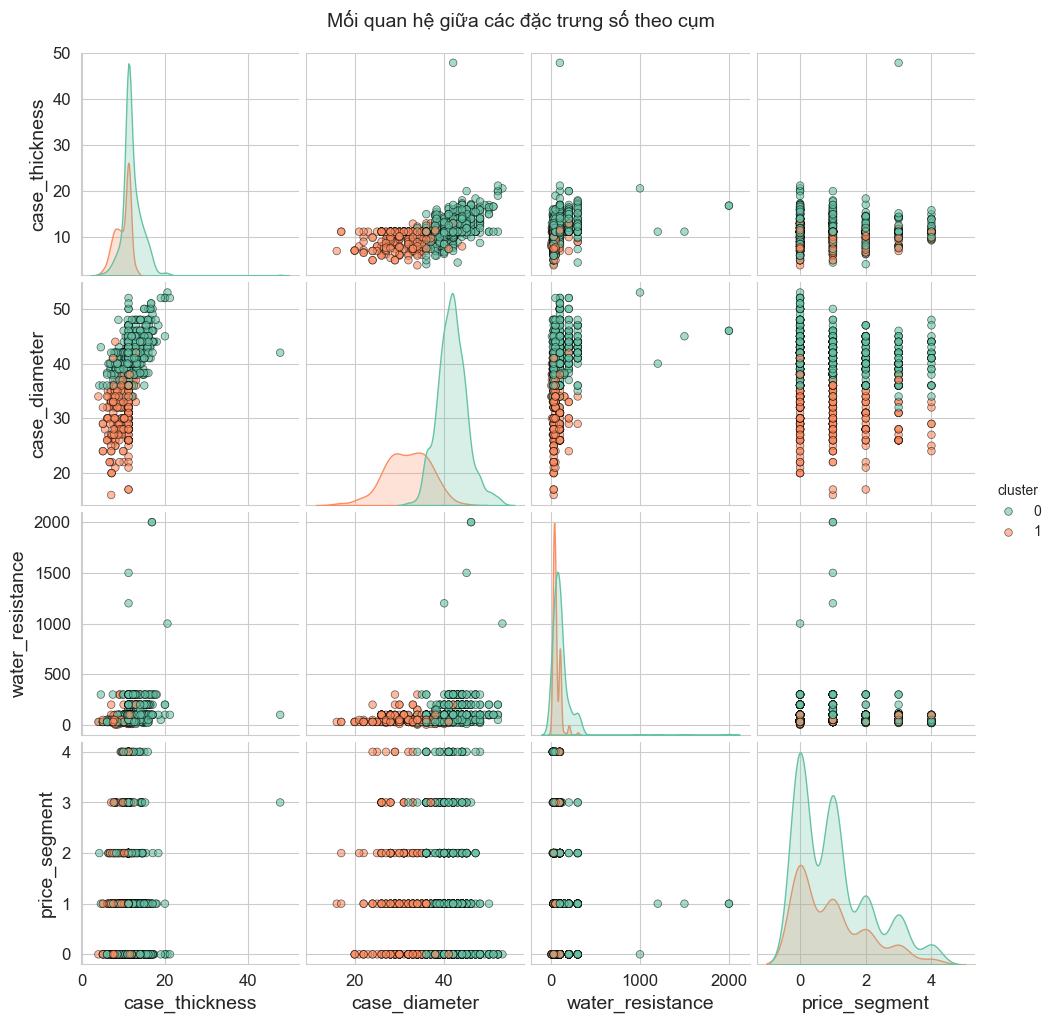

In [32]:
# Pairplot - Hiển thị mối quan hệ giữa các đặc trưng theo cặp
sns.pairplot(df_sample, vars=numerical_cols + ['price_segment'], hue='cluster', palette='Set2', 
             height=2.5, plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Mối quan hệ giữa các đặc trưng số theo cụm', y=1.02, fontsize=14)
plt.show()

## 9. Đặc điểm và phân loại các cụm

Dựa trên các phân tích đã thực hiện, chúng ta có thể mô tả đặc điểm của từng cụm như sau:

## Đặc điểm và Phân loại các Cụm

Dựa trên các phân tích univariate và multivariate, chúng ta có thể mô tả đặc điểm của từng cụm như sau:

### Cụm 0 (~ 67% dữ liệu): "Men's Sport & Casual Watches" (Đồng hồ thể thao & thường ngày cho nam)
- **Đặc điểm nổi bật**: 
  - Chủ yếu là đồng hồ nam
  - Kích thước mặt lớn (trung bình 41.8mm)
  - Đa số có phong cách thể thao (Sport) và thường ngày (Casual)
  - Độ chống nước trung bình (~112m)
  - Phần lớn ở phân khúc giá thấp đến trung bình

### Cụm 1 (~ 33% dữ liệu): "Women's Luxury & Fashion Watches" (Đồng hồ cao cấp & thời trang cho nữ)
- **Đặc điểm nổi bật**:
  - Chủ yếu là đồng hồ nữ
  - Kích thước mặt nhỏ (trung bình 32mm)
  - Đa số có phong cách sang trọng (Luxury) và thời trang (Fashion)
  - Độ chống nước thấp (~58m)
  - Phân bố ở nhiều phân khúc giá, nhưng tập trung ở phân khúc cao cấp
  - Thường có các thương hiệu cao cấp (Rolex, Cartier, Omega)

### Cụm 2 (< 1% dữ liệu): "Professional Diving Watches" (Đồng hồ lặn chuyên nghiệp)
- **Đặc điểm nổi bật**:
  - Cụm nhỏ, rất đặc biệt
  - Kích thước mặt lớn (trung bình 43.7mm)
  - Độ chống nước cực cao (4100m)
  - Chủ yếu là đồng hồ lặn chuyên nghiệp
  - Phân khúc giá cao

Những phân cụm này có thể giúp các nhà bán lẻ đồng hồ phân loại sản phẩm, phát triển chiến lược tiếp thị nhắm mục tiêu, và đưa ra các đề xuất sản phẩm phù hợp hơn cho khách hàng.

## 10. Kết luận

Agglomerative Clustering đã giúp chúng ta phân chia dữ liệu đồng hồ thành các cụm có ý nghĩa, với các đặc điểm riêng biệt. Phương pháp này hiệu quả trong việc phát hiện các nhóm tự nhiên trong dữ liệu, kể cả khi các cụm có kích thước không đồng đều.

### Ưu điểm của kết quả phân cụm:
- Tạo ra các phân khúc khách hàng rõ ràng
- Phân biệt rõ các loại đồng hồ theo đặc điểm kỹ thuật và phong cách
- Phát hiện các nhóm sản phẩm đặc biệt (như đồng hồ lặn chuyên nghiệp)

### Ứng dụng thực tế:
- Cá nhân hóa đề xuất sản phẩm
- Phân khúc thị trường và định vị sản phẩm
- Tối ưu hóa chiến lược định giá
- Phát triển sản phẩm mới nhắm đến các phân khúc cụ thể